In [ ]:
# Усов Руслан Николаевич
# Тема преддипломной практики: «Разработка алгоритмов машинного обучения для обнаружения ошибок в текстах (на примере Частного образовательного учреждения высшего образования «Московский университет имени С.Ю. Витте»)»

# Построение модели

## Установка зависимостей

In [ ]:
## Установка зависимостей

print("Начало установки зависимостей...")
!pip install pandas scikit-learn tensorflow matplotlib numpy
print("Установка зависимостей завершена.")

## Импорты

In [ ]:
print("Импорт библиотек - начало")
import os
import json
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib
import matplotlib.pyplot as plt
print("Библиотеки импортированы:")

print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('tensorflow', tf.__version__)


Установка зависимостей и импорт библиотек - начало
Зависимости установлены и библиотеки импортированы:
matplotlib 3.10.3
numpy 2.1.3
tensorflow 2.19.0


## Создание единой конфигурации для модели

In [ ]:
print("Конфигурация - начало")
config = {
    "max_vocab_size": 15000,
    "max_sequence_len": 25,
    "embedding_dim": 128,
    "lstm_units": 64,
    "dropout_rate": 0.3,
    "batch_size": 64,
    "epochs": 15,
    "patience": 3,
    "model_dir": "../model/model.keras",
    "best_model_path": "../model/bm/best_model.keras"
}
print(f"Конфиг установлен: {config}")

Конфигурация - начало
Конфиг установлен: {'max_vocab_size': 15000, 'max_sequence_len': 25, 'embedding_dim': 128, 'lstm_units': 64, 'dropout_rate': 0.3, 'batch_size': 64, 'epochs': 15, 'patience': 3, 'model_dir': '../model/model.keras', 'best_model_path': '../model/b2/best_model.keras'}


## Загрузка df, создание словаря

In [4]:
# Загрузка и подготовка данных
print("Загрузка датасета - начало")
df = pd.read_csv("../data/processed/dataset.csv")
print(f"Загружено {len(df)} записей")
# Приводим к строкам и убираем NaN
for col in ["noisy", "correct"]:
    df[col] = df[col].fillna("").astype(str)
# Создаем словарь исправлений
corrections = dict(zip(df["noisy"], df["correct"]))
# Готовим тексты и метки
texts = df["noisy"].tolist() + df["correct"].tolist()
labels = [1] * len(df) + [0] * len(df)
print("Данные загружены и очищены")

Загрузка датасета - начало
Загружено 39119 записей
Данные загружены и очищены


## Предобработка текста (char-level)

In [5]:
# Предобработка текста (char-level)
print("Предобработка - начало")
assert all(isinstance(t, str) for t in texts), "Некоторые тексты не являются строками!"
tokenizer = Tokenizer(char_level=True, num_words=config["max_vocab_size"], oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=config["max_sequence_len"], padding='post')
labels_array = np.array(labels)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(padded, labels_array, test_size=0.2, random_state=42)
print("Предобработка выолнена: char-level последовательности созданы")

Предобработка - начало
Предобработка выолнена: char-level последовательности созданы


In [ ]:
# Сериализуем в JSON tokenizer и экспортируем
print('Начало сериализации')

# Создаём папку, если её нет
output_path = "../model/tokenizer/tokenizer.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Сохраняем токенайзер
tokenizer_json = tokenizer.to_json()
with open(output_path, "w", encoding="utf-8") as f:
    f.write(tokenizer_json)

print('Сериализация завершена')

Начало сериализации
Сериализация завершена


## Построение модели

In [9]:
# Построение модели
print("Построение модели - начало")

def build_model():
    print("Функция build_model: начало - создание LSTM классификатора")
    model = Sequential([
        Embedding(input_dim=config["max_vocab_size"], output_dim=config["embedding_dim"], input_shape=(config["max_sequence_len"],)),
        tf.keras.layers.SpatialDropout1D(config["dropout_rate"]),
        Bidirectional(LSTM(config["lstm_units"], dropout=config["dropout_rate"], recurrent_dropout=config["dropout_rate"])),
        tf.keras.layers.Dropout(config["dropout_rate"]),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("Функция build_model: завершение - модель построена и скомпилирована")
    return model

model = build_model()
model.build(input_shape=(None, config["max_sequence_len"]))
print("Модель готова к обучению")
model.summary()

Построение модели - начало
Функция build_model: начало - создание LSTM классификатора


c:\Users\Rreeo\.conda\envs\test_env\lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Функция build_model: завершение - модель построена и скомпилирована
Модель готова к обучению


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 25, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 25, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,018,945 (7.70 MB)

 Trainable params: 2,018,945 (7.70 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение модели с class_weight и колбэками

In [11]:
# Обучение модели с class_weight и колбэками
print("Обучение - начало")
from sklearn.utils import class_weight
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: cw_val for i, cw_val in enumerate(cw)}
print(f"Ячейка 6: class_weight установлены: {class_weights}")

checkpoint = ModelCheckpoint(
    filepath=config["best_model_path"], monitor='val_accuracy', mode='max', save_best_only=True, verbose=1
)
earlystop = EarlyStopping(
    monitor='val_loss', patience=config['patience'], restore_best_weights=True, verbose=1
)
history = model.fit(
    X_train, y_train,
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[checkpoint, earlystop]
)

# Сохраняем финальную модель
final_path = config.get("model_dir", None)
if final_path:
    model.save(final_path)
    print(f"Финальная модель сохранёна по пути: {final_path}")
    
print("Обучение завершено")

Обучение - начало
Ячейка 6: class_weight установлены: {0: np.float64(0.998755345630944), 1: np.float64(1.0012477604299974)}
Epoch 1/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6942 - loss: 0.5726
Epoch 1: val_accuracy improved from -inf to 0.72233, saving model to ../model/b2/best_model.keras
978/978 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.6942 - loss: 0.5726 - val_accuracy: 0.7223 - val_loss: 0.5374
Epoch 2/15
977/978 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6989 - loss: 0.5688
Epoch 2: val_accuracy improved from 0.72233 to 0.72981, saving model to ../model/b2/best_model.keras
978/978 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.6989 - loss: 0.5688 - val_accuracy: 0.7298 - val_loss: 0.5338
Epoch 3/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6985 - loss: 0.5637
Epoch 3: val_accuracy did not improve from 0.72981
978/978 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.6985 - loss: 0.5637 - val_accuracy: 0.7253 - val_loss: 0.5304
Epoch 4/

## Графики обучения и потерь

Построение графиков - начало


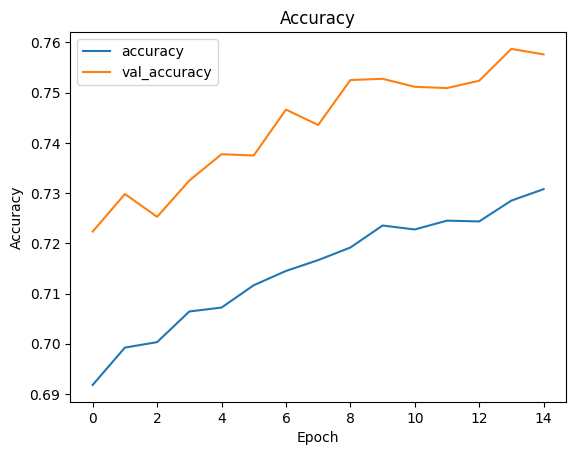

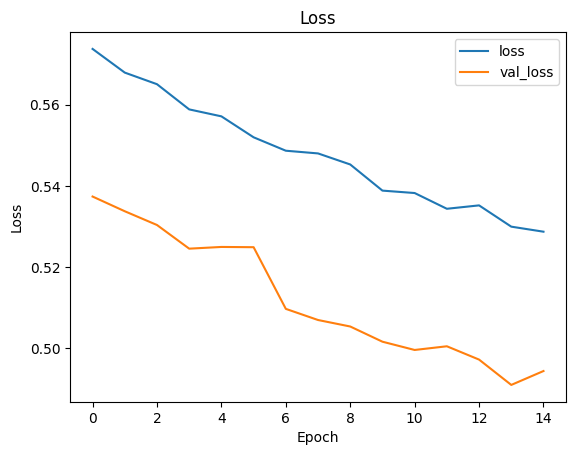

Графики построены


In [13]:
# Графики обучения и потерь
print("Построение графиков - начало")
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../src/model-stat/accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../src/model-stat/loss.png', dpi=300, bbox_inches='tight')
plt.show()

print("Графики построены")